In [2]:
from sklearn.datasets import fetch_openml # MNIST 다운받기
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
x,y = mnist["data"],mnist["target"] # data와 lable 가져오기

In [4]:
import numpy as np
x.shape,y.shape
y = y.astype(np.uint8)

(-0.5, 27.5, 27.5, -0.5)

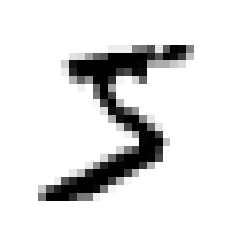

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 배열로 된 입력된 값 이미지로 구현하기

some_digit = x[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')

In [6]:
y[0]

5

In [7]:
# train data와 test data 나누기
x_train,x_test,y_train,y_test = x[:60000],x[60000:],y[:60000],y[60000:]

# 이진 분류 훈련(5판별기)

In [8]:
# 벡터 타깃 만들기
y_train_5 = (y_train==5) # numpy.ndarray를 bool로 바꿔준다.
y_test_5 = (y_test==5)


In [9]:
# 확률적 경사하강법 사용
# 사이킷런 SGDClassifier

from sklearn.linear_model import SGDClassifier

sdg_clf = SGDClassifier(random_state=42)
sdg_clf.fit(x_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sdg_clf.predict([some_digit])

array([ True])

## 성능측정

In [11]:
# 교차검증 2장에서 사용한 cross_val_score() 와 유사한 방법을 직접 구현

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds =  StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(x_train,y_train_5):
    
    clone_clf = clone(sdg_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_cross = sum(y_pred == y_test_fold)
    print(n_cross/len(y_pred))

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sdg_clf,x_train,y_train_5,cv=10,scoring='accuracy')

array([0.96416667, 0.95866667, 0.96416667, 0.95833333, 0.96733333,
       0.96933333, 0.96433333, 0.96583333, 0.9575    , 0.96566667])

In [13]:
# 그냥 5가 아니라고 하는 함수 만들기

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
     
    def fit(self,x,y=None):
        return self
    
    def predict(self,x):
        return np.zeros((len(x),1),dtype=bool)

In [14]:
never_5_classifier = Never5Classifier()
cross_val_score(never_5_classifier,x_train,y_train_5,cv=5,scoring='accuracy')

#결과가 정확도 90을 넘는다 특정 레이블이 다른 것보다 월등히 많을 경우 적합하지 않은 검증법이다.

array([0.91266667, 0.90866667, 0.9095    , 0.90883333, 0.90858333])

## 오차 행렬

In [15]:
'''
1. 실제 값과 비교할 수 있는 예측값을 만든다.cross_val_preict() 를 이용한다.
2. 오차 행렬을 만든다. confusion_matricx() 를 이용한다.
'''

'\n1. 실제 값과 비교할 수 있는 예측값을 만든다.cross_val_preict() 를 이용한다.\n2. 오차 행렬을 만든다. confusion_matricx() 를 이용한다.\n'

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sdg_clf,x_train,y_train_5,cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
# 정밀도, 재현율 함수

from sklearn.metrics import precision_score, recall_score

a = precision_score(y_train_5,y_train_pred) # 정밀도
b = recall_score(y_train_5,y_train_pred) # 재현율
print(a,b)

0.8370879772350012 0.6511713705958311


In [19]:
# F1 점수 (정밀도와 재현율의 조화 평균)

from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [20]:
# 임곗값을 입력하여 정밀도, 재현율 조정하기
# predict() 함수 대신 decision_function() 사용하여 점수를 얻는다.

y_score = sdg_clf.decision_function([some_digit])
print(y_score)

tresholds = 0 # 임곗값
y_some_digit_pred = (y_score > tresholds)
print(y_some_digit_pred)

tresholds = 8000 # 임곗값
y_some_digit_pred = (y_score > tresholds)
print(y_some_digit_pred)

#임곗값 설정에 따라 결과가 다르게 반환된다.

[2164.22030239]
[ True]
[False]


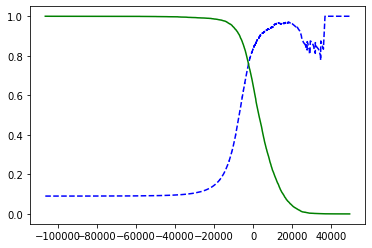

In [21]:
# 정밀도, 재현율 그래프 그리기

y_scores = cross_val_predict(sdg_clf,x_train,y_train_5,cv=3,method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.plot(thresholds, precisions[:-1],'b--',label='정밀도')
    plt.plot(thresholds, recalls[:-1],'g-',label='재현율')
    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

In [22]:
precisions[-1],recalls[-1]

(1.0, 0.0)

In [23]:
# 목표치에 따른 임계값 찾기
threshold_90_precison = thresholds[np.argmax(precisions>= 0.95)]
threshold_90_precison

10480.508645329957

In [24]:
y_train_pred_90 = (y_scores >= threshold_90_precison) # y_score = 각 test별 점수(임곗값)를 담고 있다 원하는 임곗값 이상만 True인 리스트 만들기

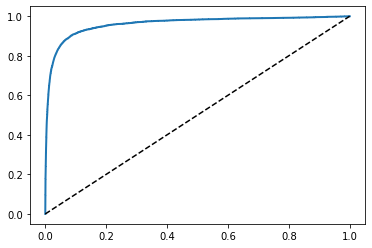

In [25]:
# ROC 곡선 그리기
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')

plot_roc_curve(fpr,tpr)

In [26]:
# 곡선아래 면적 AUC 를 이용한 분류기 비교

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

## RandomForestClassifier 사용하기

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,x_train,y_train_5,cv=3,method='predict_proba') 

#RandomForestClassifier에는 decision_function()이 없어서 predict_proba를 사용한다. (점수가 아닌 퍼센트로 반환) 

In [28]:
y_scores_forest = y_probas_forest[:,1] # 확률값

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53

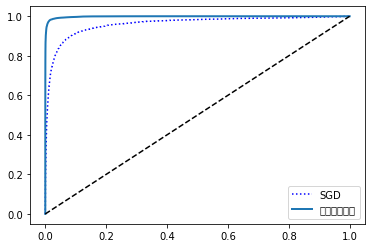

In [29]:
plt.plot(fpr,tpr,'b:',label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'랜덤포레스트')
plt.legend(loc='lower right')

In [30]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [31]:
y_train_pred_forest = cross_val_predict(forest_clf,x_train,y_train_5,cv=3)

In [32]:
a = precision_score(y_train_5,y_train_pred_forest) # 정밀도
b = recall_score(y_train_5,y_train_pred_forest) # 재현율
print(a,b)

0.9905083315756169 0.8662608374838591
